In [1]:
from itertools import chain
import numpy as np
from midiutil import *
import pygame

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
track = 0
channel = 0
#pitch = 120
pitch = 60
pitch1 = 60
time = 0
duration = 1
volume = 100


In [3]:
def blank_midifile():
    MyMIDI = MIDIFile(1)
    return MyMIDI

#for i in range(12):
#    MyMIDI.addNote(track,channel,pitch+i,time+i,duration,volume)

In [4]:
intervals = {'prim':0,
             'minor_second':1,
             'major_second':2,
             'minor_third':3,
             'major_third':4,
             'fourth':5,
             'tritone':6,
             'fifth':7,
             'minor_sixth':8,
             'major_sixth':9,
             'minor_seventh':10,
             'major_seventh':11,
             'octave':12
            }

In [5]:
major = [0, 2, 4, 5, 7, 9, 11] + [12 + x for x in [0, 2, 4, 5, 7, 9, 11]]

In [6]:
def major_chord(chord_numeral, jazzness=0):
    return major[chord_numeral-1::2][:(3+jazzness)]
major_chord(2, 5)

[2, 5, 9, 12, 16, 19, 23]

In [7]:
class Tone:
    def __init__(self, root, interval, duration=1, volume=100, parent=None, time=None):
        if parent is None and time is None:
            time = 0
        self.parent = parent
        self.time = time    
        self.root = root
        if type(interval) == str:
            self.interval = intervals[interval]
        else:
            self.interval = interval
        self.duration = duration
        self.volume = volume
        
    #def __getattr__(self, name):
    def __getattribute__(self, name):
        if name == 'time' and self.parent is not None:
            return self.parent.time + self.parent.duration
        else:
            return object.__getattribute__(self,name)
            
    
    def add_note(self, midi_file, track, channel):
        if self.parent is not None:
            time = self.parent.time + self.parent.duration
        elif self.time is not None:
            time = self.time
        else:
            raise ValueError("Parent and/or time was messed with - don't do that!")
        
        midi_file.addNote(track, channel, self.root + self.interval, time, self.duration, self.volume)

In [8]:
class Chord:
    def __init__(self, root, constituents, duration=1, volume=100, parent=None, time=None):
        if parent is None and time is None:
            time = 0
        self.parent = parent
        self.time = time    
        self.root = root
        self.constituents = []
        for interval in constituents:
            if type(interval) == str:
                self.constituents.append(intervals[interval])
            else:
                self.constituents.append(interval)
        self.duration = duration
        self.volume = volume

    def __getattribute__(self, name):
        if name == 'time' and self.parent is not None:
            return self.parent.time + self.parent.duration
        else:
            return object.__getattribute__(self,name)
            
    
    def add_note(self, midi_file, track, channel):
        if self.parent is not None:
            time = self.parent.time + self.parent.duration
        elif self.time is not None:
            time = self.time
        else:
            raise ValueError("Parent and/or time was messed with - don't do that!")
        
        for interval in self.constituents:
            midi_file.addNote(track, channel, self.root + interval, time, self.duration, self.volume)

In [9]:
major_scale = np.array([0,2,4,5,7,9,11])

In [10]:
major_scale_probabilities = np.eye(12)[major_scale].sum(0)/7

In [11]:
melody = []
signs = []
rhythm = []
for _ in range(4):
    length = 0
    while length < 4:
        note = np.random.choice(range(0, 12), size = 1, p = major_scale_probabilities)
        #sign = np.random.choice([-1,1],size=1)
        sign = 1
        #duration = np.random.choice([0.25,0.5,1,1.25, 1.5, 1.75, 2], size=1)
        duration = np.random.choice([0.25,0.5,1, 2], size=1)
        melody.append(note)
        signs.append(sign)
        if duration > (4 - length):
            duration = 4 - length
        rhythm.append(duration)
        length += duration

In [12]:
length

array([4.])

In [13]:
melody = np.array(melody).flatten()
rhythm = np.array(rhythm).flatten()
signs = np.array(signs).flatten()

In [14]:
midi_file = blank_midifile()
the_lick = []
the_lick.append(Tone(pitch, 1, 0.5, time=0))
for interval, duration in [(2, 0.5), (3, 0.5), (5, 0.5), (2, 1), (-2, 0.5), (0, 1.5)]:
    the_lick.append(Tone(pitch, interval, duration, parent=the_lick[-1]))

for x in the_lick:
    x.add_note(midi_file, track, channel)

In [46]:
midi_file = blank_midifile()
midi_file.addProgramChange(track, channel+1, 0, 8)
random_music = []
pitches = melody*sign
random_music.append(Tone(60, pitches[0], rhythm[0], time=0))
for interval, duration in zip(pitches[1:], rhythm[1:]):
    random_music.append(Tone(pitch, interval, duration, parent=random_music[-1]))

for x in random_music:
    x.add_note(midi_file, track, channel)

In [47]:
#midi_file = blank_midifile()
c = Chord(pitch, major_chord(2, jazzness=1), duration=4)
d = Chord(pitch, major_chord(5, jazzness=1), duration=4, parent=c)
e = Chord(pitch, major_chord(1, jazzness=1), duration=4, parent=d)
f = Chord(pitch, major_chord(1, jazzness=1), duration=4, parent=e)
c.add_note(midi_file, track, channel+1)
d.add_note(midi_file, track, channel+1)
e.add_note(midi_file, track, channel+1)
f.add_note(midi_file, track, channel+1)

print(c.constituents)
print(d.constituents)
print(e.constituents)
print(f.constituents)

[2, 5, 9, 12]
[7, 11, 14, 17]
[0, 4, 7, 11]
[0, 4, 7, 11]


In [48]:
for midi_track in midi_file.tracks:
    midi_track.closeTrack()
with open('tmp.mid','wb') as f:
    midi_file.writeFile(f)

In [49]:
def play_music(midi_filename):
  '''Stream music_file in a blocking manner'''
  clock = pygame.time.Clock()
  pygame.mixer.music.load(midi_filename)
  pygame.mixer.music.play()
  while pygame.mixer.music.get_busy():
    clock.tick(30) # check if playback has finished

In [ ]:
# mixer config
freq = 44100  # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2  # 1 is mono, 2 is stereo
buffer = 1024   # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)

# listen for interruptions
#try:
  # use the midi file you just saved
play_music('tmp.mid')
#except KeyboardInterrupt:
  ## if user hits Ctrl/C then exit
  ## (works only in console mode)
  #pygame.mixer.music.fadeout(1000)
  #pygame.mixer.music.stop()
  #raise SystemExit

In [51]:
import matplotlib.pylab as plt

In [52]:
x = np.cumsum(rhythm)

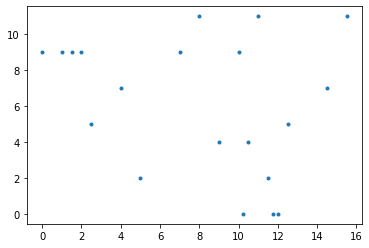

In [53]:
plt.plot([0] + list(x[:-1]), melody,'.')